<a href="https://colab.research.google.com/github/alagarde-bit/Computer-Vision/blob/main/lab14ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Day 17 Tutorial - Artifical Neural Networks with Tensorflow
Adapted from:
- Tensorflow image classification tutorial https://www.tensorflow.org/tutorials/images/classification
- Practical Machine Learning for Computer Vision by Lakshmanan


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## Get the data

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15VrN2Bc-7fZd1Z4JH55H_B-o47A5ZhVW',
                                    dest_path= '/content/animals.zip',
                                    unzip=True)

## Visualize an example image

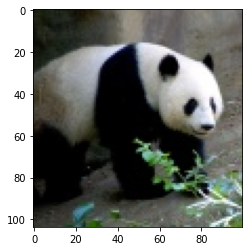

In [ ]:
bgr = cv2.imread('animals/panda/panda_00001.jpg')
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()

# Set some parameters
We'll process images in batches of 32 at a time, and we'll resize each image to 180 x 180.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180


In [ ]:
# This is the folder where our images are
data_dir = 'animals'

# Tensorflow will choose some of the images as training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [ ]:
# Tensorflow will chooose the rest of the images as validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [ ]:
# The class names (the names of the different types of images) are
# automatically inferred from the folder names.
class_names = train_ds.class_names
print(class_names)


['cats', 'dogs', 'panda']


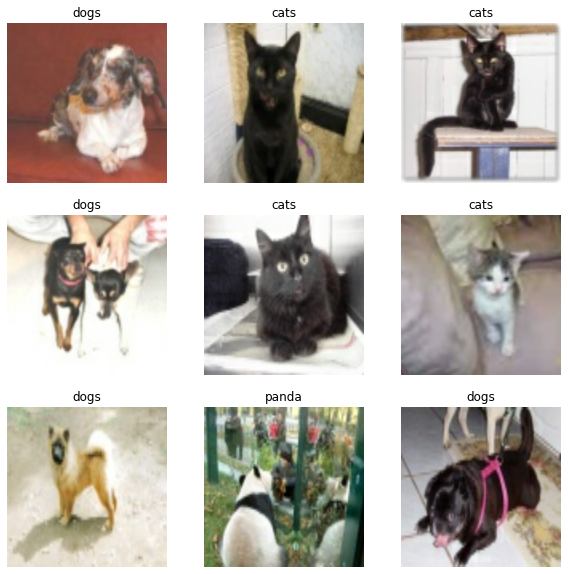

In [ ]:
# The Tensorflow train_ds object makes it easy to get to the images and 
# visualize them
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Set a few values to make performance better for loading images

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## Create the neural network (model)

In [ ]:
num_classes = len(class_names)

# The model will first normalize the pixel values into the range 0-1.
# Then flatten the images so each is a long vector of numbers.
# Then connect that to a hidden (Dense) layer with 32 neurons.
# Then create 3 outputs, one per class.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,                  
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(24, activation='relu'),
  layers.Dense(24, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
# Compiling the model gets it ready to train.
# We tell it which optimizer to use to find the best weights (Adam),
# What the learning rate is (how big a step to take while optimizing),
# and what loss function to use, and what metrics to keep track of (accuracy).
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
# Print out a summary of the layers of the model.
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 flatten_6 (Flatten)         (None, 97200)             0         
                                                                 
 dense_25 (Dense)            (None, 32)                3110432   
                                                                 
 dense_26 (Dense)            (None, 24)                792       
                                                                 
 dense_27 (Dense)            (None, 24)                600       
                                                                 
 dense_28 (Dense)            (None, 3)               

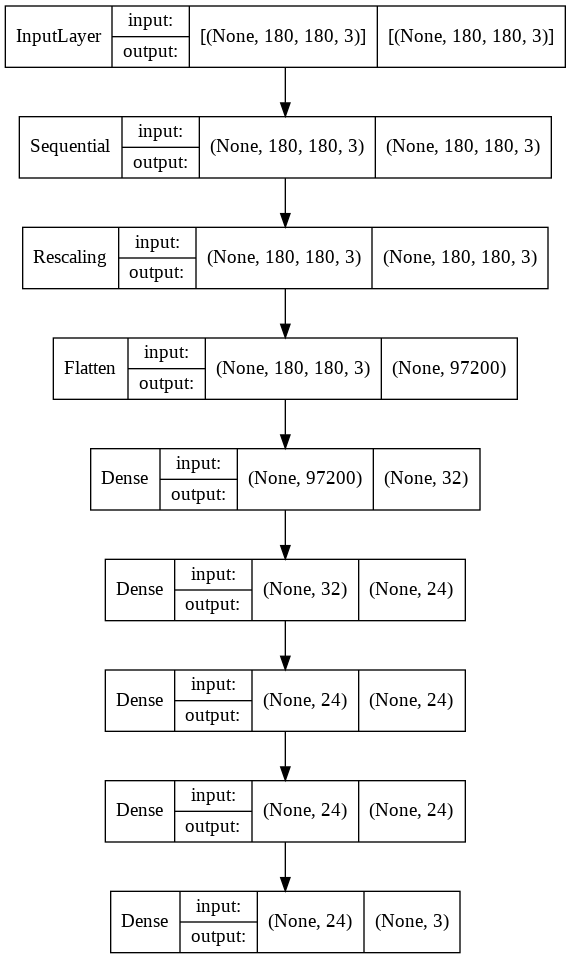

In [ ]:
# Visualize the layers of the model.
# (None, 180, 180, 3) means that the model can handle various numbers of images,
# but they all have to be 180x180 and have 3 color channels.
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

## Train (fit) the model
An epoch is one iteration of training, where the model sees each training example one time.

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50
75/75 [==============================] - 3s 20ms/step - loss: 1.0624 - accuracy: 0.3479 - val_loss: 1.0381 - val_accuracy: 0.4083
Epoch 2/50
75/75 [==============================] - 1s 18ms/step - loss: 1.0207 - accuracy: 0.4096 - val_loss: 1.0118 - val_accuracy: 0.4667
Epoch 3/50
75/75 [==============================] - 1s 18ms/step - loss: 1.0013 - accuracy: 0.4796 - val_loss: 0.9846 - val_accuracy: 0.5200
Epoch 4/50
75/75 [==============================] - 1s 18ms/step - loss: 0.9801 - accuracy: 0.5192 - val_loss: 0.9550 - val_accuracy: 0.5617
Epoch 5/50
75/75 [==============================] - 1s 18ms/step - loss: 0.9495 - accuracy: 0.5362 - val_loss: 0.9317 - val_accuracy: 0.5850
Epoch 6/50
75/75 [==============================] - 1s 18ms/step - loss: 0.9302 - accuracy: 0.5554 - val_loss: 0.9143 - val_accuracy: 0.5700
Epoch 7/50
75/75 [==============================] - 1s 18ms/step - loss: 0.9131 - accuracy: 0.5512 - val_loss: 0.8967 - val_accuracy: 0.5917
Epoch 8/50
75

## Visualize the results

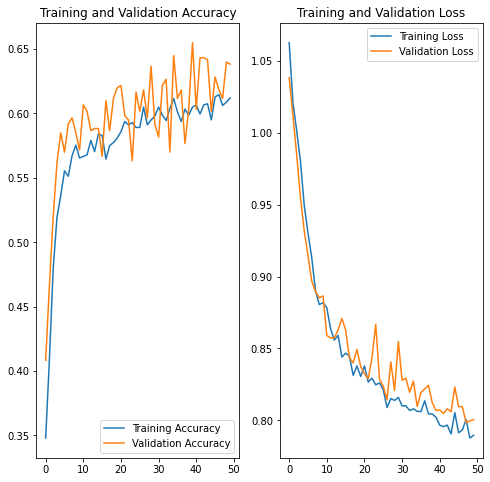

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

4b. When changing the learning rate from 0.001 to 0.0001, there is a big increase in training and testing data accuracy. The curves on the plots are less jagged and zig zag looking. When changing rate to 0.00001, there is a minimal increase in training and testing data accuracy, with far smoother curves and a little more work to do. 

4c. After 10 epochs, when augmenting data the testing accuracy increased from 32 to 47% and the training data increased from 33% to 49% accuracy. Instead of a flat validation accuracy curve, the curve decends too. 

6. The best I could get after playing around a little bit was an accuracy of about 64% for the testing data after having added the data augmentation, a learning rate of 0.00001, and two hidden layers with 24 neurons each after having seen that around 2/3 of the number input neurons added to the number of output neurons was a formula for number of hidden layer neurons. 

## Download a new image and predict it with the trained model.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1557k  100 1557k    0     0  6205k      0 --:--:-- --:--:-- --:--:-- 6205k


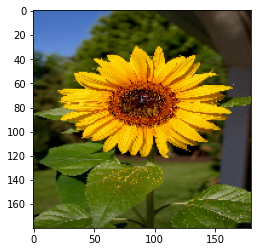

Predictions:
[[-13.053972 -12.978719  -7.913576]]
Probabilities:
tf.Tensor([0.00578498 0.00623711 0.98797786], shape=(3,), dtype=float32)
This image most likely belongs to sunflower with a 98.80 percent confidence.


In [ ]:
url = 'https://images.unsplash.com/photo-1566669086984-077347c1f4bb?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=679&q=80'

!curl -o download.png {url}
img = cv2.imread('download.png')
img = cv2.resize(img, (img_width, img_height))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Reshape it so that it is 1 x h x w x 3
# (The first 1 puts the image in a batch of size 1)
img_array = np.reshape(img, (1, img_height, img_width, 3))

# Predict the image with the model
predictions = model.predict(img_array)
print('Predictions:')
print(predictions)

# Use softmax to convert the scores coming out of the neural network
# into probabilities (sum to 1)
score = tf.nn.softmax(predictions[0])
print('Probabilities:')
print(score)

# Figure out which class is predicted based on the highest probability
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


# What if the image doesn't look like any of the training examples? The model will still try to make a prediction.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1557k  100 1557k    0     0  13.1M      0 --:--:-- --:--:-- --:--:-- 13.2M


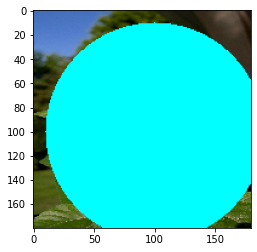

Predictions:
[[21.754622   23.072601   -0.51908517]]
Probabilities:
tf.Tensor([2.1115460e-01 7.8884542e-01 4.4797395e-11], shape=(3,), dtype=float32)
This image most likely belongs to daisy with a 78.88 percent confidence.


In [ ]:
url = 'https://images.unsplash.com/photo-1566669086984-077347c1f4bb?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=679&q=80'

!curl -o download.png {url}
img = cv2.imread('download.png')
img = cv2.resize(img, (img_width, img_height))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw a big circle on the image to see how it affects the prediction
img = cv2.circle(img, (100, 100), 90, (0, 255, 255), -1)

plt.imshow(img)
plt.show()

# Reshape it so that it is 1 x h x w x 3
# (The first 1 puts the image in a batch of size 1)
img_array = np.reshape(img, (1, img_height, img_width, 3))

# Predict the image with the model
predictions = model.predict(img_array)
print('Predictions:')
print(predictions)

# Use softmax to convert the scores coming out of the neural network
# into probabilities (sum to 1)
score = tf.nn.softmax(predictions[0])
print('Probabilities:')
print(score)

# Figure out which class is predicted based on the highest probability
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

